<a href="https://colab.research.google.com/github/UzunDemir/Deep_Learning/blob/main/mnist_fashion_v1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Для воспроизводимости кода установим определённую версию TensorFlow и Keras.

In [5]:
!pip install -q tensorflow #==2.1

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [7]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.18.0
We are using Keras 3.8.0


In [ ]:
# Проверяем, что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla P4 (UUID: GPU-6c8de2e0-035b-6e99-b331-5c08526a6178)


In [ ]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Mon Apr  6 20:47:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    23W /  75W |    115MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# MNIST

In [8]:
# Скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
# Что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


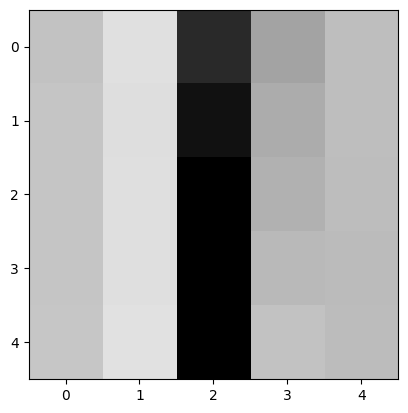

Пример картинки:


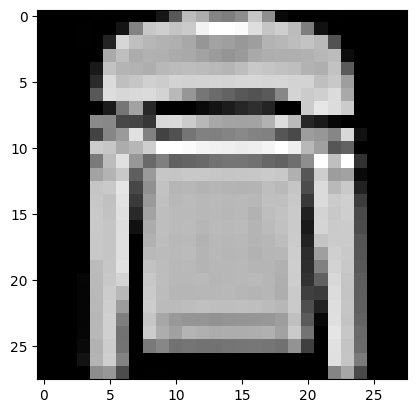

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [10]:
# Нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

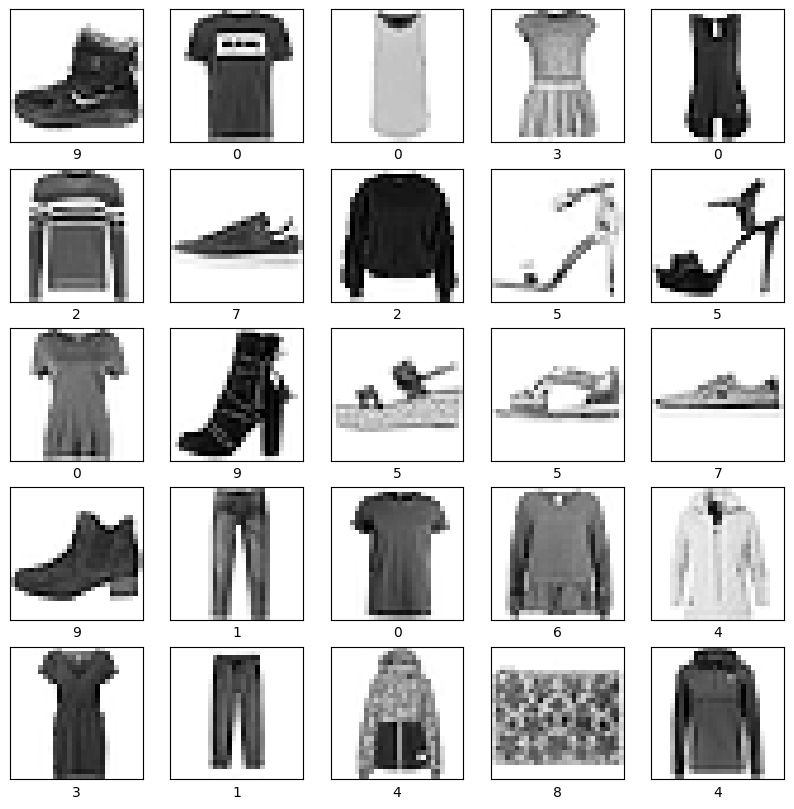

In [11]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

# Data

In [12]:
# Вытянем картинку в вектор размера 28 * 28 = 784 и будем использовать это как фичу!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [14]:
# Центрируем и нормируем, так сети будет проще учиться
#x_train_float = x_train_flat.astype(np.float) / 255 - 0.5
#x_val_float = x_val_flat.astype(np.float) / 255 - 0.5

# По сути, эти действия аналогичны нормализации через StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите, что будет ;)
# x_train_float = x_train_flat.astype(np.float)
# x_val_float = x_val_flat.astype(np.float)

# Альтернативный вариант с float (встроенный тип Python)
x_train_float = x_train_flat.astype(float) / 255 - 0.5
x_val_float = x_val_flat.astype(float) / 255 - 0.5

In [15]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


# Собираем модель

Самостоятельно постройте Multilayer Perceptron (MLP) классификатор (по аналогии с практической частью, но на новых данных).

In [16]:
clear_session()

In [17]:
# Здесь ваш код архитектуры сети
# Не забудьте 10 выходов с активацией Softmax на выходном слое!
# model = Sequential()
# model.add(Dense(..., input_shape=(28*28,))) # первый скрытый слой
# ...
model = Sequential([
    # Первый скрытый слой (128 нейронов, ReLU-активация)
    Dense(128, activation='relu', input_shape=(28*28,)),

    # Второй скрытый слой (64 нейрона, ReLU)
    Dense(64, activation='relu'),

    # Выходной слой (10 нейронов = 10 классов, softmax)
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаете, что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [20]:
history = model.fit(
                    x_train_float,
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчёта градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7767 - loss: 0.6383 - val_accuracy: 0.8458 - val_loss: 0.4307
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8598 - loss: 0.3845 - val_accuracy: 0.8534 - val_loss: 0.3967
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8761 - loss: 0.3371 - val_accuracy: 0.8689 - val_loss: 0.3639
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8819 - loss: 0.3185 - val_accuracy: 0.8658 - val_loss: 0.3735
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8912 - loss: 0.2930 - val_accuracy: 0.8646 - val_loss: 0.3873
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8968 - loss: 0.2746 - val_accuracy: 0.8769 - val_loss: 0.3445
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9007 - loss: 0.2636 - val_accuracy: 0.8796 - val_loss: 0.3437
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9061 - loss: 0.2489 - val_accuracy: 0.

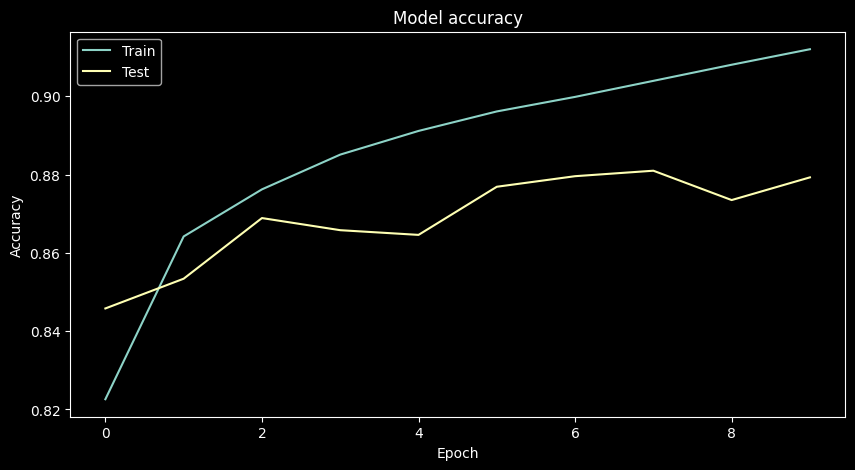

In [21]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

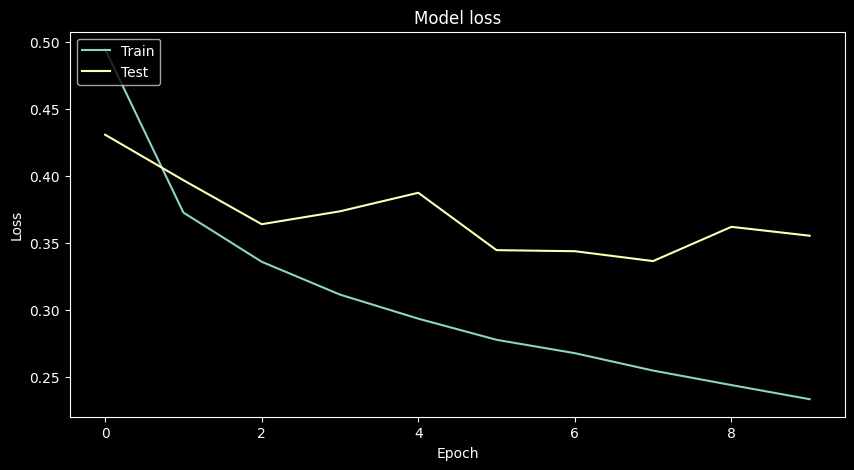

In [22]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
predicts = model.predict_classes(x_val_float)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [25]:
# Получаем вероятности классов (формат: [batch_size, 10])
y_probs = model.predict(x_val_float)

# Преобразуем в предсказанные метки (argmax по axis=1)
predicts = np.argmax(y_probs, axis=1)

# Считаем accuracy
print('Test Accuracy:', accuracy_score(y_val, predicts))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.8793


Что вам необходимо сделать:
1. Обучите сеть без скрытых слоёв (постройте аналог обычной линейной модели). **Какое значение accuracy на валидации получили?**
2. Обучите сеть с двумя скрытыми слоями по 128 нейронов в каждом. **Какое значение accuracy на валидации получили?**
3. **Сколько параметров в последней сети?**

Удачи!

#Мои исследования


Что можно улучшить?
Добавить Dropout/BatchNorm – для борьбы с переобучением:

```python
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  # "Выключает" 30%
```

In [29]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization  # Добавлен импорт BatchNormalization
from tensorflow.keras.optimizers import Adam
# Очистка сессии
tf.keras.backend.clear_session()

# Создание модели
model = Sequential([
    # Первый скрытый слой + BatchNorm
    Dense(256, activation='relu', input_shape=(28*28,)),
    BatchNormalization(),
    Dropout(0.3),  # Дропаут 30%

    # Второй скрытый слой + BatchNorm
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Выходной слой
    Dense(10, activation='softmax')
])

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Обучение модели
history = model.fit(
    x_train_float,
    y_train_oh,
    batch_size=64,
    epochs=10,
    validation_data=(x_val_float, y_val_oh),
    verbose=1
)

# Оценка точности
y_probs = model.predict(x_val_float)
predicts = np.argmax(y_probs, axis=1)
print('Test Accuracy:', accuracy_score(y_val, predicts))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7439 - loss: 0.7570 - val_accuracy: 0.8340 - val_loss: 0.4608
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8320 - loss: 0.4724 - val_accuracy: 0.8445 - val_loss: 0.4318
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8420 - loss: 0.4418 - val_accuracy: 0.8428 - val_loss: 0.4270
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8477 - loss: 0.4229 - val_accuracy: 0.8537 - val_loss: 0.4053
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8543 - loss: 0.4069 - val_accuracy: 0.8582 - val_loss: 0.3983
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8585 - loss: 0.3924 - val_accuracy: 0.8524 - val_loss: 0.4016
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8621 - loss: 0.3854 - val_accuracy: 0.8657 - val_loss: 0.3770
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8622 - loss: 0.3766 - val_accurac

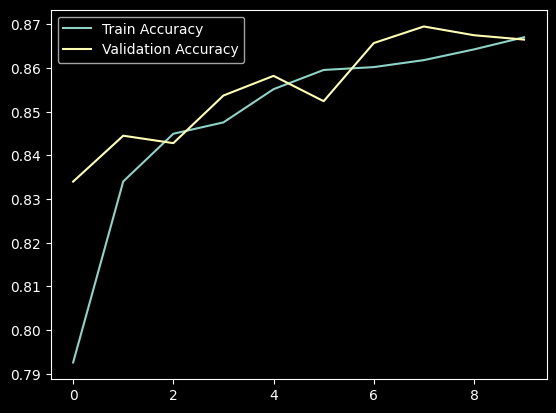

In [30]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

##1. Линейная модель (без скрытых слоёв)

Accuracy линейной модели: 0.8378


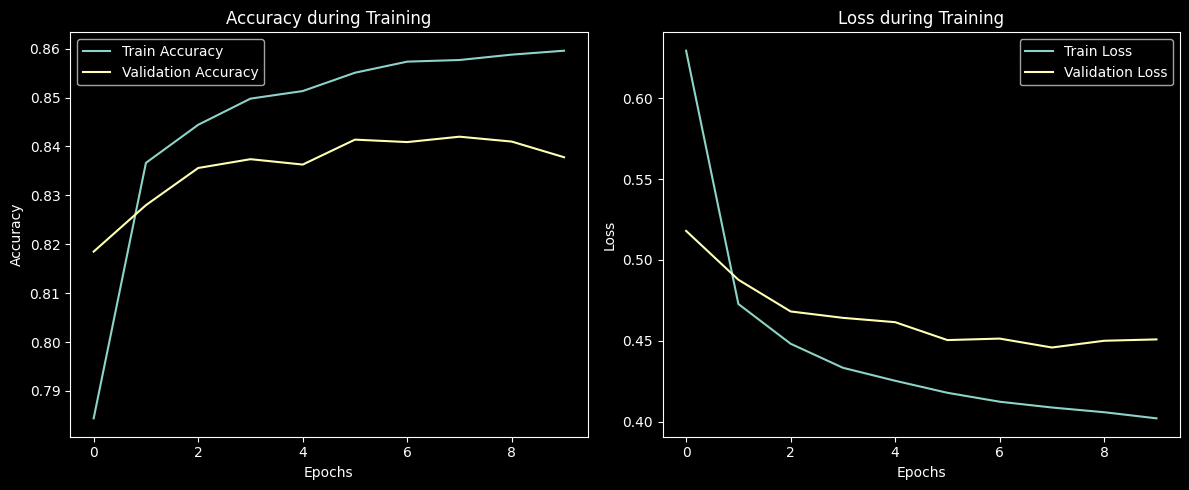

In [32]:
import matplotlib.pyplot as plt

# Очищаем сессию
tf.keras.backend.clear_session()

# Создаём модель только с выходным слоем (аналог логистической регрессии)
model_linear = Sequential([
    Dense(10, activation='softmax', input_shape=(28*28,))
])

# Компилируем
model_linear.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Обучаем
history_linear = model_linear.fit(
    x_train_float,
    y_train_oh,
    batch_size=64,
    epochs=10,
    validation_data=(x_val_float, y_val_oh),
    verbose=0
)

# Оценка
val_accuracy_linear = history_linear.history['val_accuracy'][-1]
print(f'Accuracy линейной модели: {val_accuracy_linear:.4f}')

# Визуализация
plt.figure(figsize=(12, 5))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history_linear.history['accuracy'], label='Train Accuracy')
plt.plot(history_linear.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history_linear.history['loss'], label='Train Loss')
plt.plot(history_linear.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Cеть с двумя скрытыми слоями по 128 нейронов в каждом

Accuracy сети с 2 слоями: 0.8828


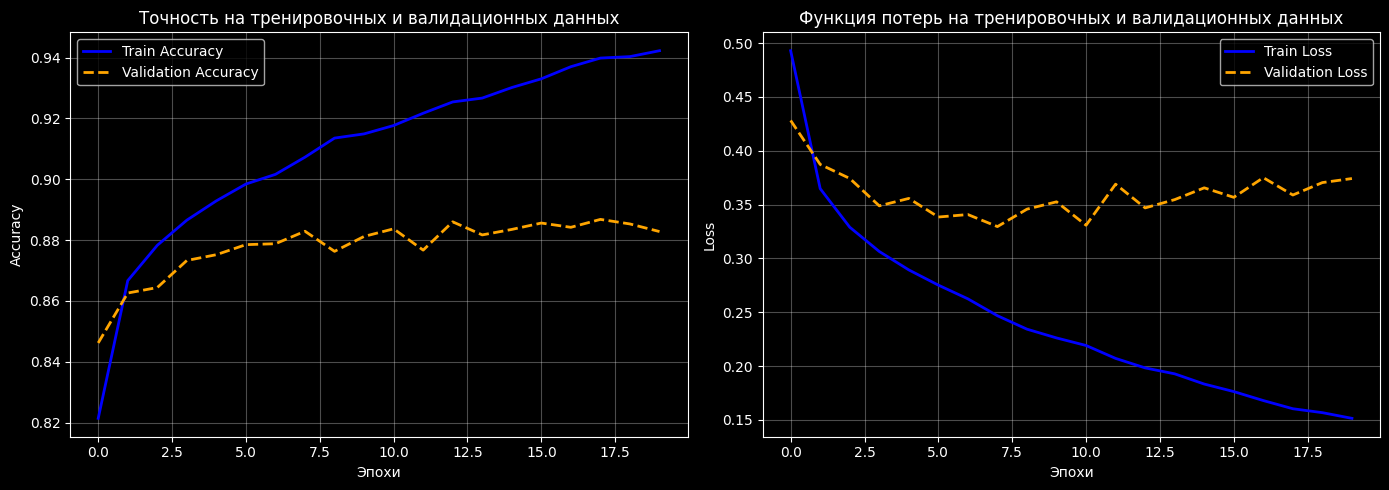


Итоговые метрики:
Последняя train accuracy: 0.9422
Последняя val accuracy: 0.8828
Минимальная train loss: 0.1515
Минимальная val loss: 0.3296


In [33]:
# Очищаем сессию
tf.keras.backend.clear_session()

# Создаём модель
model_deep = Sequential([
    Dense(128, activation='relu', input_shape=(28*28,)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Компилируем
model_deep.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Обучаем
history_deep = model_deep.fit(
    x_train_float,
    y_train_oh,
    batch_size=64,
    epochs=20,
    validation_data=(x_val_float, y_val_oh),
    verbose=0
)

# Оценка
val_accuracy_deep = history_deep.history['val_accuracy'][-1]
print(f'Accuracy сети с 2 слоями: {val_accuracy_deep:.4f}')

# Визуализация прогресса по эпохам
plt.figure(figsize=(14, 5))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history_deep.history['accuracy'],
         label='Train Accuracy',
         color='blue',
         linewidth=2)
plt.plot(history_deep.history['val_accuracy'],
         label='Validation Accuracy',
         color='orange',
         linewidth=2,
         linestyle='--')
plt.title('Точность на тренировочных и валидационных данных', fontsize=12)
plt.xlabel('Эпохи', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history_deep.history['loss'],
         label='Train Loss',
         color='blue',
         linewidth=2)
plt.plot(history_deep.history['val_loss'],
         label='Validation Loss',
         color='orange',
         linewidth=2,
         linestyle='--')
plt.title('Функция потерь на тренировочных и валидационных данных', fontsize=12)
plt.xlabel('Эпохи', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Выводим итоговые метрики
print('\nИтоговые метрики:')
print(f"Последняя train accuracy: {history_deep.history['accuracy'][-1]:.4f}")
print(f"Последняя val accuracy: {history_deep.history['val_accuracy'][-1]:.4f}")
print(f"Минимальная train loss: {min(history_deep.history['loss']):.4f}")
print(f"Минимальная val loss: {min(history_deep.history['val_loss']):.4f}")

## Сколько параметров в последней сети?

In [34]:
model_deep.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 354,848 (1.35 MB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,566 (924.09 KB)

## Эксперименты со слоями

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7272 - loss: 0.7973 - val_accuracy: 0.8275 - val_loss: 0.4743
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8345 - loss: 0.4551 - val_accuracy: 0.8353 - val_loss: 0.4615
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8501 - loss: 0.4175 - val_accuracy: 0.8470 - val_loss: 0.4083
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8533 - loss: 0.4048 - val_accuracy: 0.8560 - val_loss: 0.4475
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8613 - loss: 0.3850 - val_accuracy: 0.8571 - val_loss: 0.4090
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8653 - loss: 0.3627 - val_accuracy: 0.8656 - val_loss: 0.3761
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8727 - loss: 0.3531 - val_accuracy: 0.8513 - val_loss: 0.4258
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8714 - loss: 0.3488 - val_accuracy

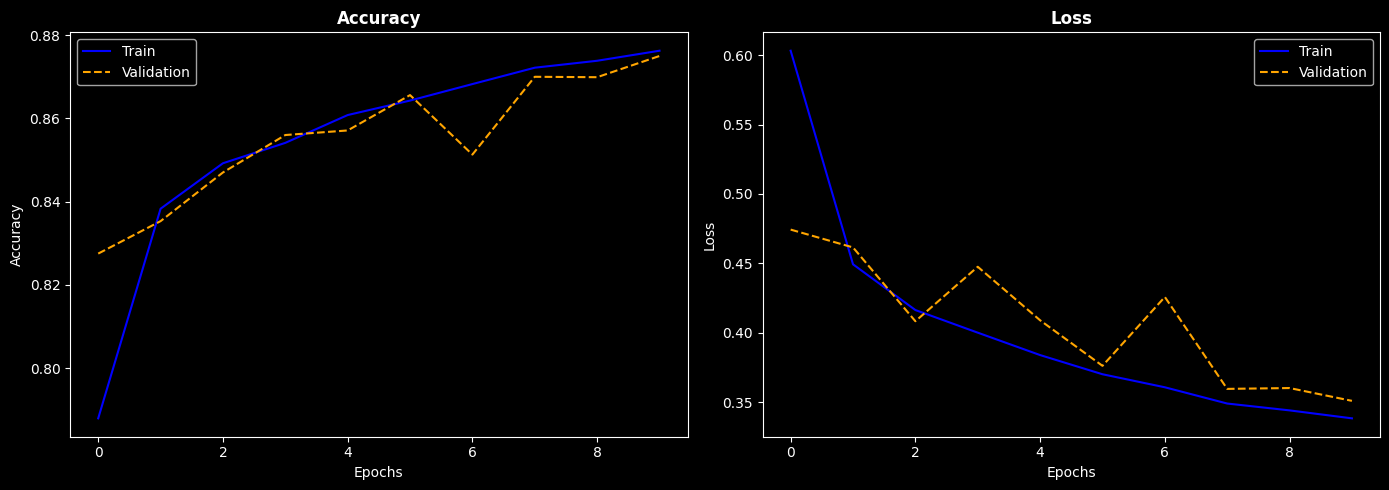

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 407,456 (1.55 MB)

 Trainable params: 135,562 (529.54 KB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 271,126 (1.03 MB)

In [38]:
# Очистка сессии
tf.keras.backend.clear_session()

# Создание модели с 3 скрытыми слоями
model = Sequential([
    Dense(128, activation='relu', input_shape=(28*28,)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),  # Новый слой
    BatchNormalization(),
    Dropout(0.2),

    Dense(10, activation='softmax')
])

# Компиляция
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Обучение
history = model.fit(
    x_train_flat,
    y_train_oh,
    batch_size=64,
    epochs=10,
    validation_data=(x_val_flat, y_val_oh),
    verbose=1
)

# Оценка
y_probs = model.predict(x_val_flat)
y_pred = np.argmax(y_probs, axis=1)
print(f'\nTest Accuracy: {accuracy_score(y_val, y_pred):.4f}')

# Визуализация
plt.figure(figsize=(14, 5))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation', color='orange', linestyle='--')
plt.title('Accuracy', fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', color='blue')
plt.plot(history.history['val_loss'], label='Validation', color='orange', linestyle='--')
plt.title('Loss', fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Вывод информации о модели
model.summary()

## При добавлении слоёв качество модели ухудшается, это может быть вызвано несколькими причинами.


### 1. Проблема исчезающих градиентов

В глубоких сетях градиенты могут становиться слишком малыми при обратном распространении

*Решение: попробовать BatchNormalization и правильные функции активации*

### 2. Переобучение

Слишком сложная модель запоминает шумы в данных

*Решение: Увеличить регуляризацию (Dropout, L2)*

### 3. Плохая инициализация весов

*Решение: указать kernel_initializer='he_normal' для ReLU*

### 4. Слишком агрессивный Dropout

Большие значения (например, 0.5+) могут мешать обучению

*Решение: Уменьшить Dropout до 0.2-0.3*